# Loading the data

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [2]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 65.9MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 103MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 30.7MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.1MB/s]


# Preparing the data

In [3]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('train.csv')
print(train_data)

        Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
0        1          60       RL  ...        WD         Normal    208500
1        2          20       RL  ...        WD         Normal    181500
2        3          60       RL  ...        WD         Normal    223500
3        4          70       RL  ...        WD        Abnorml    140000
4        5          60       RL  ...        WD         Normal    250000
...    ...         ...      ...  ...       ...            ...       ...
1455  1456          60       RL  ...        WD         Normal    175000
1456  1457          20       RL  ...        WD         Normal    210000
1457  1458          70       RL  ...        WD         Normal    266500
1458  1459          20       RL  ...        WD         Normal    142125
1459  1460          20       RL  ...        WD         Normal    147500

[1460 rows x 81 columns]


We need a way to handle the columns with class data.

In [4]:
class_names = ["MSZoning", "Street", "Alley", "LotShape", 
                "LandContour", "Utilities", "LotConfig", "LandSlope", 
                "Neighborhood", "Condition1", "Condition2", "BldgType", 
                "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
                "Exterior2nd", "ExterQual", "ExterCond", "Foundation", 
                "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
                "BsmtFinType2", "Heating", "CentralAir", "Electrical", 
                "KitchenQual", "Functional", "FireplaceQu", "GarageType", 
                "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", 
                "PoolQC", "Fence", "MiscFeature", "SaleType", "SaleCondition"]

We'll search for each of those columns every possible value, so we assign a value to each. The 0 will be the null value.

In [5]:
def classify(name, data):
  #get different classes
  group = []
  for i in range(len(data)):
    val = data.iloc[i][name]
    if val not in group and not pd.isnull(val):
      group.append(val)

  #create dictionary
  dicti = {}
  for i in range(len(group)):
    dicti[group[i]] = (i + 1) #null value is 0

  return dicti

We build a dictionary so we can reference it when cleaning the data.

In [6]:
def getReferences(names, data):
  references = []
  for name in names:
    references.append(classify(name, data))
  return references

In [7]:
class_ref = getReferences(class_names, train_data)

for ref in class_ref:
  print(ref)

{'RL': 1, 'RM': 2, 'C (all)': 3, 'FV': 4, 'RH': 5}
{'Pave': 1, 'Grvl': 2}
{'Grvl': 1, 'Pave': 2}
{'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}
{'Lvl': 1, 'Bnk': 2, 'Low': 3, 'HLS': 4}
{'AllPub': 1, 'NoSeWa': 2}
{'Inside': 1, 'FR2': 2, 'Corner': 3, 'CulDSac': 4, 'FR3': 5}
{'Gtl': 1, 'Mod': 2, 'Sev': 3}
{'CollgCr': 1, 'Veenker': 2, 'Crawfor': 3, 'NoRidge': 4, 'Mitchel': 5, 'Somerst': 6, 'NWAmes': 7, 'OldTown': 8, 'BrkSide': 9, 'Sawyer': 10, 'NridgHt': 11, 'NAmes': 12, 'SawyerW': 13, 'IDOTRR': 14, 'MeadowV': 15, 'Edwards': 16, 'Timber': 17, 'Gilbert': 18, 'StoneBr': 19, 'ClearCr': 20, 'NPkVill': 21, 'Blmngtn': 22, 'BrDale': 23, 'SWISU': 24, 'Blueste': 25}
{'Norm': 1, 'Feedr': 2, 'PosN': 3, 'Artery': 4, 'RRAe': 5, 'RRNn': 6, 'RRAn': 7, 'PosA': 8, 'RRNe': 9}
{'Norm': 1, 'Artery': 2, 'RRNn': 3, 'Feedr': 4, 'PosN': 5, 'PosA': 6, 'RRAn': 7, 'RRAe': 8}
{'1Fam': 1, '2fmCon': 2, 'Duplex': 3, 'TwnhsE': 4, 'Twnhs': 5}
{'2Story': 1, '1Story': 2, '1.5Fin': 3, '1.5Unf': 4, 'SFoyer': 5, 'SLvl': 6, '2.5Unf':

Now remain the columns which have values.

In [8]:
number_names = ["MSSubClass", "LotFrontage", "LotArea", "OverallQual", 
                "OverallCond", "YearBuilt", "YearRemodAdd", "MasVnrArea", 
                "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", 
                "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", 
                "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", 
                "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", 
                "GarageYrBlt", "GarageCars", "GarageArea", "WoodDeckSF", 
                "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", 
                "PoolArea", "MiscVal", "MoSold", "YrSold"]

So we can create a dataset object which will clean the data and prepare it.

In [43]:
import torch
from torch.utils.data import Dataset, DataLoader

class HousingDataset(Dataset):
  def __init__(self, data, mode, class_ref, class_names, number_names):
    self.data = data
    self.mode = mode # train or test
    self.class_ref = class_ref
    self.class_names = class_names
    self.number_names = number_names
  
  def __getitem__(self, index):
    item = self.data.iloc[index]
    input = []

    # id of the item
    id = item["Id"]

    # every class 
    for i in range(len(self.class_names)):
      name = self.class_names[i]
      if not pd.isnull(item[name]):
        c = class_ref[i][item[name]]
        input.append(c)
      else:
        input.append(0)
    
    # every number
    for name in self.number_names:
      value = item[name]
      value = 0 if pd.isnull(value) else float(value)
      input.append(value)

    if self.mode == "train":
      # the target
      label = item["SalePrice"]
      return torch.tensor(input, dtype=torch.float), torch.tensor(label, dtype=torch.float), torch.tensor(id, dtype=torch.int)
    else:
      return torch.tensor(input, dtype=torch.float), torch.tensor(id, dtype=torch.int)
    
  def __len__(self):
    return len(self.data)

Let's take training data and split it, into training dataset (70%) and into a validation dataset (30%), and create a loader object.

In [44]:
dataset = HousingDataset(train_data, "train", class_ref, class_names, number_names)

train_size = int(0.7 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

print("Training dataset size: " + str(train_size))
print("Validation dataset size: " + str(valid_size))

Training dataset size: 1021
Validation dataset size: 439


# Prepare the model

Let us define a simple linear model.

In [127]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class HousingModel(nn.Module):
    def __init__(self, n_input):
        super(HousingModel, self).__init__()
        self.l1 = nn.Linear(n_input, 40)
        self.l2 = nn.Linear(40, 40)
        self.l3 = nn.Linear(40, 20)
        self.l4 = nn.Linear(20, 1)

        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.drop(x)
        x = F.relu(self.l1(x))
        x = self.drop(x)
        x = F.relu(self.l2(x))
        x = self.drop(x)
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return x

Define the model, loss function and optimizer

In [12]:
# root mean square error loss
class RMSE(torch.nn.Module):
    def __init__(self):
        super(RMSE,self).__init__()

    def forward(self, x, y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [128]:
model = HousingModel(77).to(device)
model.loss_function = RMSE()
model.optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model

Let's create the code to train the model.

In [37]:
def train(model, loader):
  model.train()
  sum_loss = 0

  for i, (inputs, labels, ids) in enumerate(loader):
    # inputs
    inputs, labels = inputs.to(device), labels.to(device)

    # forwards
    model.optimizer.zero_grad()
    outputs = model(inputs)

    # backwards
    loss = model.loss_function(outputs, labels.unsqueeze(1))
    loss.backward()
    model.optimizer.step()

    # stats
    sum_loss += loss.item()

  avg_loss = sum_loss / len(loader)
  return avg_loss

And the code to test on the validation set.

In [38]:
def eval(model, loader):
  model.eval()
  sum_loss = 0
  results = []
  targets = []

  for i, (inputs, labels, ids) in enumerate(loader):
    # inputs
    inputs, labels = inputs.to(device), labels.to(device)

    # forwards
    outputs = model(inputs)

    # the loss
    sum_loss += model.loss_function(outputs, labels.unsqueeze(1))

    # get the results and corresponding target
    results.extend(outputs.squeeze(1).detach().numpy())
    targets.extend(labels.detach().numpy())

  avg_loss = sum_loss / len(loader)
  return avg_loss, results, targets

So we can create the code which will improve the model over multiple iterations. At each epoch we train the model and then test the model on the validation set.

In [39]:
def improve(model, train_loader, valid_loader, n_epoch):
  train_losses = []
  valid_losses = []

  for epoch in range(n_epoch):
    print("Epoch " + str(epoch))

    # train
    train_loss = train(model, train_loader)
    train_losses.append(train_loss)

    # validate
    valid_loss, results, targets = eval(model, valid_loader)
    valid_losses.append(valid_loss)

  return train_losses, valid_losses

And train the model for 50 epochs.

In [129]:
train_losses, valid_losses = improve(model, train_loader, valid_loader, 50)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


If we plot the loss over time we get:

Minimum training loss: 55832.17529296875
Minimum validation loss: tensor(48403.1836, grad_fn=<DivBackward0>)


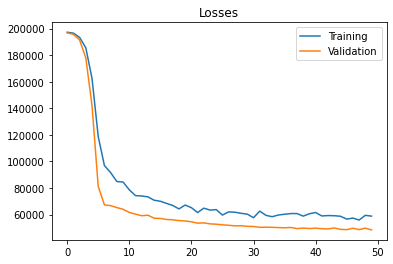

In [130]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(train_losses, label="Training")
ax.plot(valid_losses, label="Validation")
ax.set_title("Losses")
ax.legend()

print("Minimum training loss: " + str(min(train_losses)))
print("Minimum validation loss: " + str(min(valid_losses)))

# A look at the predictions

I have intentionally added to the evaluation code the output of the model and the corresponding label so we can visualize it. The idea is to put the target as x values, and the result as y values.

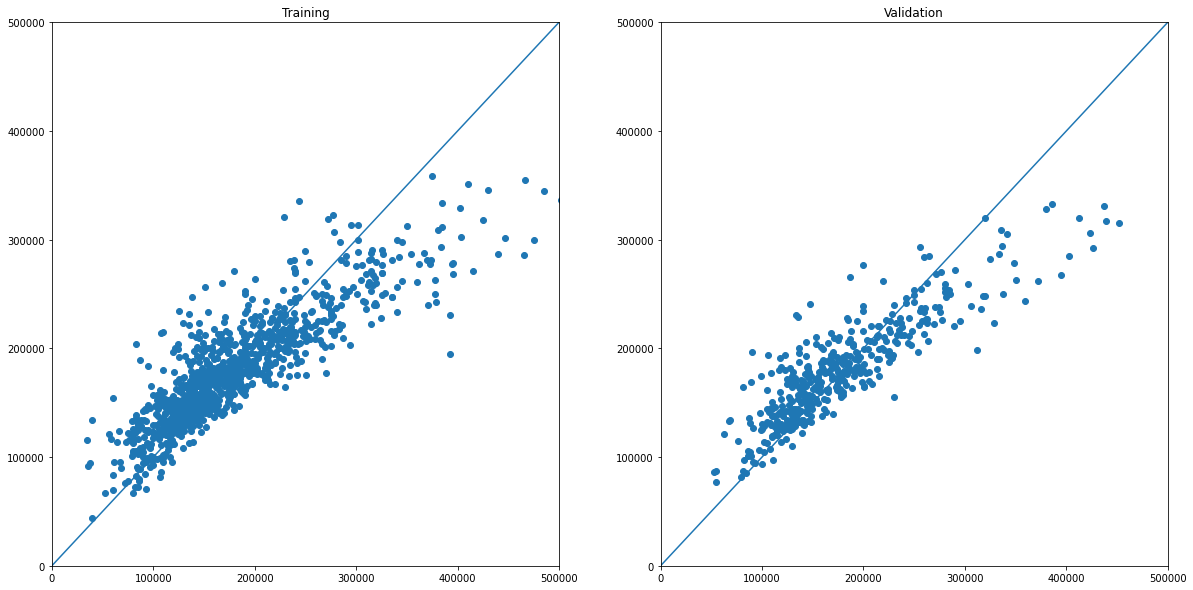

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
lim = [0, 500000]
plt.setp(ax, xlim=lim, ylim=lim)

# training
train_loss, train_results, train_targets = eval(model, train_loader)
ax[0].plot(lim, lim), ax[0].set_title("Training")
ax[0].scatter(train_targets, train_results)

# validation
valid_loss, valid_results, valid_targets = eval(model, valid_loader)
ax[1].plot(lim, lim), ax[1].set_title("Validation")
ax[1].scatter(valid_targets, valid_results)

The ideal model would put every point on the diagonal, because then the result would correspond to the target. We see here the model tends to overestimate the price over the cheaper appartements, and underestimate the prive of the expensive appartements. But why is that the case?

# Improving the model further

The problem is we have already a bias in the data, there are way more cheaper appartement than more expensive appartement. So the loss function tries to minimize the overall loss, which means the lower appartement have a higher importance.

(array([ 11.,  38.,  99., 232., 273., 218., 176., 104.,  93.,  58.,  42.,
         35.,  24.,  10.,  17.,   8.,   7.,   4.,   2.,   1.,   1.,   2.,
          1.,   0.,   2.,   0.,   0.,   0.,   0.,   2.]),
 array([ 34900.        ,  58903.33333333,  82906.66666667, 106910.        ,
        130913.33333333, 154916.66666667, 178920.        , 202923.33333333,
        226926.66666667, 250930.        , 274933.33333333, 298936.66666667,
        322940.        , 346943.33333333, 370946.66666667, 394950.        ,
        418953.33333333, 442956.66666667, 466960.        , 490963.33333333,
        514966.66666667, 538970.        , 562973.33333333, 586976.66666667,
        610980.        , 634983.33333333, 658986.66666667, 682990.        ,
        706993.33333333, 730996.66666667, 755000.        ]),
 <a list of 30 Patch objects>)

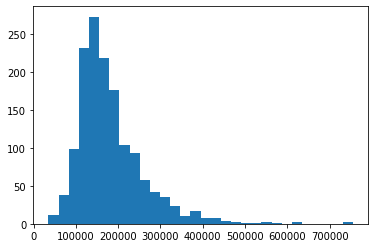

In [132]:
sale_price = train_data["SalePrice"]
plt.hist(sale_price, bins=30)

# Upload to Kaggle

In [45]:
test_data = pd.read_csv('test.csv')
test_dataset = HousingDataset(test_data, "test", class_ref, class_names, number_names)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We expect similar accuracy on the leaderboard. However, the overfitting is clear. Let us prepare the submission file.

In [106]:
def get_submission(model, test_loader):
  ids = []
  predictions = []

  with torch.no_grad():
      for inputs, id in test_loader:
          outputs = model(inputs)
          ids.extend(id.detach().numpy())
          predictions.extend(outputs.squeeze(1).detach().numpy())

  results = pd.DataFrame({
    "Id": ids,
    "SalePrice": predictions
    })
  
  return results

In [107]:
results = get_submission(model, test_loader)
results.to_csv("housing_submission.csv", index=False)